In [1]:
matrix_destination = "matrix.cellQC.geneQC.normalised.hk_controls.rds"
source("load_matrix.R")

Loading required package: SummarizedExperiment
Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdiff, sort,
    table, tapply, union, unique, unsp

In [2]:
library(data.table)
library(ccRemover)
# https://cran.r-project.org/web/packages/ccRemover/vignettes/ccRemover_tutorial.html


Attaching package: ‘data.table’

The following object is masked from ‘package:SummarizedExperiment’:

    shift

The following object is masked from ‘package:GenomicRanges’:

    shift

The following object is masked from ‘package:IRanges’:

    shift

The following objects are masked from ‘package:S4Vectors’:

    first, second



### Removing the Cell-Cycle Effect

Here we will remove the cell-cycle effect on our data to help remove variability that is not related to cell-type differentiation.

To use this tool, we must first re-normalise our gene data once more so that it is zero-centric. 

In [3]:
mean_gene_exp <- rowMeans(logcounts(sce))
t_cell_data_cen <- logcounts(sce) - mean_gene_exp

gret <- rbind(
    summary(apply(t.cell_data,1, mean)),
    summary(apply(t_cell_data_cen,1,mean))
)

rownames(gret) <- c("Before ZeroNorm:", "After ZeroNorm:")
gret


,Min.,1st Qu.,Median,Mean,3rd Qu.,Max.
Before ZeroNorm:,3.920000e-02,8.990159e-01,1.573755e+00,1.620198e+00,2.281749e+00,5.137184e+00
After ZeroNorm:,-7.132621e-16,-5.216573e-17,8.147944e-19,9.961007e-19,5.231419e-17,4.408021e-16


We can see now that our data is correctly normalised with a mean value that is practically zero.


## Identifying the cell-cycle genes

Now we need to find sets of genes that are related to the cell-cycle so that ccRemove can correct for them. Luckily it provides an inbuilt tool that checks against a variety of different sources (in our case, ensembl).

In [4]:
gene_names <- rownames(t_cell_data_cen)
cut_gene_names <- lapply(gene_names, function(x){return(strsplit(x, "-|\\s")[[1]][1])})
cell_cycle_gene_indices <- gene_indexer(cut_gene_names, species = "mouse", name_type = "ensemble")

if_cc <- rep(FALSE,nrow(t_cell_data_cen)) 
if_cc[cell_cycle_gene_indices] <- TRUE
summary(if_cc)

dat <- list(x=t_cell_data_cen, if_cc=if_cc)

Invalid name type input. Switching to NULLNo name format input.
Checking to see if match can be found:
Best guess is  symbol  IDs
678  matches out of a possible  5052


   Mode   FALSE    TRUE 
logical    4374     678 

So now we have 678 genes that are implicit with cell-cycle variations. We can now correct against them:

In [5]:
xhat <- ccRemover(dat, bar=FALSE)  # ~ 5 mins

0.1342043  of genes are cell-cycle genes
Iteration  1 ...
Bootstrapping...The bootstrap results on the top 10 components are:      xn_load  xy_load   diff_load t_load_boot
PC1  2.037940 1.948064 -0.08987668  -0.9284765
PC2  1.911684 1.985762  0.07407781   1.2850009
PC3  1.584400 1.539122 -0.04527822  -0.7680605
PC4  1.761098 1.743666 -0.01743173  -0.3778522
PC5  1.482708 1.533594  0.05088589   0.9130776
PC6  1.355870 1.377746  0.02187671   0.3943838
PC7  1.297191 1.391646  0.09445522   1.1700309
PC8  1.285791 1.211980 -0.07381164  -1.0886315
PC9  1.312941 1.257691 -0.05525002  -0.9888276
PC10 1.258060 1.271485  0.01342451   0.2786235
No more cell-cycle effect is detected.


In [6]:
# Add back our mean expr
xhat2 <- xhat + mean_gene_exp

In [1]:
dim(sce)
#dim()

ERROR: Error in eval(expr, envir, enclos): object 'sce' not found


Now that we have finished cleaning for the cell-cyle variation, let us take a look to see how it affects a PCA:

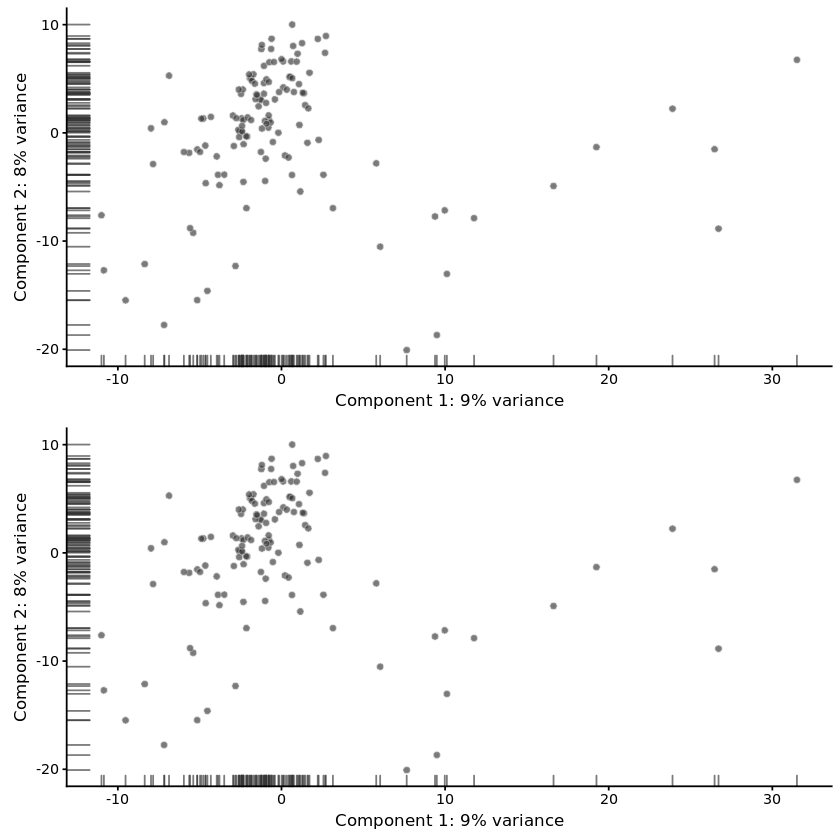

In [7]:
# clone of the original
original <- copy(sce)

# Apply xhat2 to our logcounts matrix
logcounts(sce) <- xhat2

original <- calculateQCMetrics(original)
sce <- calculateQCMetrics(sce)

# Compare PCAs
multiplot( 
    plotPCA(original, exprs_values = "logcounts"),
    plotPCA(sce, exprs_values = "logcounts")
)

The top plot is the original logcount matrix, and the bottom plot is the cell-cycle corrected logcount matrix.

As we can see, the cell-cycle variation was not significant enough to create a measurable change in biological signal.

In [8]:
saveRDS(sce, "matrix.cellQC.geneQC.normalised.hk_controls.ccClean.rds")